# Projeto 2: Emparelhamento Estável Aluno-Projeto

**Disciplina:** Teoria e Aplicação de Grafos, Turma 01, 2025/1
**Professor:** Díbio
**Autores:** Luiz Henrique Silva de Andrade e Ryan Reis Fontenele

**Objetivo:** Este notebook implementa e compara três variações do algoritmo de Gale-Shapley para resolver o problema de alocação de alunos a projetos, analisando os diferentes resultados produzidos por cada abordagem.

## 1. Importação de Bibliotecas e Configurações

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import random
from ClassCreate import Aluno, Projeto, carregarDados

# Configuração para exibir todas as linhas do DataFrame na Matriz Final
pd.set_option('display.max_rows', None)

## 2. Definição das Funções Principais

In [10]:
def tratarDados(listaDeAlunos, listaDeProjetos):
    dp, da = [], []
    for i in listaDeAlunos:
        da.append({
            'id': i.id,
            'p': i.preferencias,
            'n': i.nota,
        })
    for j in listaDeProjetos:
        dp.append({
            'id': j.id,
            'v': j.vagas,
            'nM': j.notaMinima,
        })
    da = pd.DataFrame(da).set_index('id')
    dp = pd.DataFrame(dp).set_index('id')
    print(da.head(), ' ', dp.head())
    return da, dp

def galeShapley(DadosAlunos, DadosProjetos, iteracao):
    notas_alunos = DadosAlunos['n'].to_dict()
    vagas_projetos = DadosProjetos['v'].to_dict()
    DadosAlunos['projeto_alocado'] = None
    DadosAlunos['proxima_proposta_idx'] = 0
    ordenar = list(DadosAlunos.index)
    if iteracao == 1:
        alunos_livres = ordenar
    elif iteracao == 2:
        alunos_livres = ordenar[::-1]
    else:
        alunos_livres = ordenar
        random.shuffle(alunos_livres)
    alocacoes_projetos = {proj_id: [] for proj_id in DadosProjetos.index}
    while alunos_livres:
        aluno_id = alunos_livres.pop(0)
        preferencias_aluno = DadosAlunos.loc[aluno_id, 'p']
        idx_proposta_atual = DadosAlunos.loc[aluno_id, 'proxima_proposta_idx']
        if idx_proposta_atual >= len(preferencias_aluno):
            continue
        projeto_id_alvo = preferencias_aluno[idx_proposta_atual]
        DadosAlunos.loc[aluno_id, 'proxima_proposta_idx'] += 1
        if projeto_id_alvo not in DadosProjetos.index:
            alunos_livres.append(aluno_id) # Aluno tentará a próxima preferência na sua vez
            continue # Pula para o próximo aluno livre
        # Agora que sabemos que o projeto existe, podemos pegar seus dados com segurança
        nota_aluno_atual = notas_alunos[aluno_id]
        nota_minima_projeto = DadosProjetos.loc[projeto_id_alvo, 'nM']
        if nota_aluno_atual < nota_minima_projeto:
            alunos_livres.append(aluno_id) # Proposta rejeitada, aluno tenta a próxima preferência
            continue # Pula para o próximo aluno livre
        alunos_ja_alocados = alocacoes_projetos[projeto_id_alvo]   
        if len(alunos_ja_alocados) < vagas_projetos[projeto_id_alvo]:
            alunos_ja_alocados.append(aluno_id)
            DadosAlunos.loc[aluno_id, 'projeto_alocado'] = projeto_id_alvo
        else:
            pior_aluno_id = min(alunos_ja_alocados, key=lambda id: notas_alunos[id])      
            if notas_alunos[aluno_id] > notas_alunos[pior_aluno_id]:
                alunos_ja_alocados.remove(pior_aluno_id)
                DadosAlunos.loc[pior_aluno_id, 'projeto_alocado'] = None
                alunos_livres.append(pior_aluno_id) 
                alunos_ja_alocados.append(aluno_id)
                DadosAlunos.loc[aluno_id, 'projeto_alocado'] = projeto_id_alvo
            else:
                alunos_livres.append(aluno_id)
    return DadosAlunos

def galeShapley_var1(DadosAlunos, DadosProjetos):
    preferencias_projetos = {}
    for proj_id, dados_proj in DadosProjetos.iterrows():
        candidatos_qualificados = DadosAlunos[DadosAlunos['n'] >= dados_proj['nM']]
        candidatos_interessados = candidatos_qualificados[
            candidatos_qualificados['p'].apply(lambda prefs: proj_id in prefs)
        ]
        preferencias_projetos[proj_id] = candidatos_interessados.sort_values(by='n', ascending=False).index.to_list()
    alocacao_alunos = {aluno_id: None for aluno_id in DadosAlunos.index}
    ranking_projeto_alocado = {aluno_id: float('inf') for aluno_id in DadosAlunos.index}
    projetos_livres = list(DadosProjetos.index)
    proximo_convite_idx = {proj_id: 0 for proj_id in DadosProjetos.index}
    while projetos_livres:
        projeto_id = projetos_livres.pop(0)
        vagas_preenchidas = sum(1 for aluno, proj in alocacao_alunos.items() if proj == projeto_id)
        if vagas_preenchidas >= DadosProjetos.loc[projeto_id, 'v']:
            continue 
        idx_proposta_atual = proximo_convite_idx[projeto_id]
        if idx_proposta_atual >= len(preferencias_projetos[projeto_id]):
            continue
        aluno_id_alvo = preferencias_projetos[projeto_id][idx_proposta_atual]
        proximo_convite_idx[projeto_id] += 1
        aluno_pref_list = DadosAlunos.loc[aluno_id_alvo, 'p']
        projeto_atual_do_aluno = alocacao_alunos[aluno_id_alvo]
        if projeto_atual_do_aluno is None:
            alocacao_alunos[aluno_id_alvo] = projeto_id
            ranking_projeto_alocado[aluno_id_alvo] = aluno_pref_list.index(projeto_id)
        else:
            ranking_novo_projeto = aluno_pref_list.index(projeto_id)
            if ranking_novo_projeto < ranking_projeto_alocado[aluno_id_alvo]:
                projeto_antigo_id = alocacao_alunos[aluno_id_alvo]
                alocacao_alunos[aluno_id_alvo] = projeto_id
                ranking_projeto_alocado[aluno_id_alvo] = ranking_novo_projeto
                
                if projeto_antigo_id not in projetos_livres:
                    projetos_livres.append(projeto_antigo_id)
        if projeto_id not in projetos_livres:
            projetos_livres.append(projeto_id)
    DadosAlunos['projeto_alocado'] = DadosAlunos.index.map(alocacao_alunos)
    return DadosAlunos

def galeShapley_var2(DadosAlunos, DadosProjetos):
    notas_alunos = DadosAlunos['n'].to_dict()
    vagas_projetos = DadosProjetos['v'].to_dict()
    DadosAlunos['projeto_alocado'] = None
    DadosAlunos['proxima_proposta_idx'] = 0
    alunos_livres = list(DadosAlunos.index)
    alocacoes_projetos = {proj_id: [] for proj_id in DadosProjetos.index}
    while alunos_livres:
        aluno_id = alunos_livres.pop(0)
        preferencias_aluno = DadosAlunos.loc[aluno_id, 'p']
        idx_proposta_atual = DadosAlunos.loc[aluno_id, 'proxima_proposta_idx']
        if idx_proposta_atual >= len(preferencias_aluno):
            continue
        projeto_id_alvo = preferencias_aluno[idx_proposta_atual]
        DadosAlunos.loc[aluno_id, 'proxima_proposta_idx'] += 1
        if projeto_id_alvo not in DadosProjetos.index:
            alunos_livres.append(aluno_id)
            continue
        nota_aluno_atual = notas_alunos[aluno_id]
        nota_minima_projeto = DadosProjetos.loc[projeto_id_alvo, 'nM']
        if nota_aluno_atual < nota_minima_projeto:
            alunos_livres.append(aluno_id)
            continue
        alunos_ja_alocados = alocacoes_projetos[projeto_id_alvo]
        if len(alunos_ja_alocados) < vagas_projetos[projeto_id_alvo]:
            alunos_ja_alocados.append(aluno_id)
            DadosAlunos.loc[aluno_id, 'projeto_alocado'] = projeto_id_alvo
        else:
            pior_aluno_id = min(alunos_ja_alocados, key=lambda id: notas_alunos[id])
            # --- ÚNICA MUDANÇA É AQUI: de '>' para '>=' ---
            if notas_alunos[aluno_id] >= notas_alunos[pior_aluno_id]:
                alunos_ja_alocados.remove(pior_aluno_id)
                DadosAlunos.loc[pior_aluno_id, 'projeto_alocado'] = None
                alunos_livres.append(pior_aluno_id) 
                alunos_ja_alocados.append(aluno_id)
                DadosAlunos.loc[aluno_id, 'projeto_alocado'] = projeto_id_alvo
            else:
                alunos_livres.append(aluno_id)  
    return DadosAlunos

def CalculoIndicePreferencia(DadosProcessados):
    """
    Calcula e exibe a média da ordem de preferência para cada projeto que recebeu alunos.
    Um índice menor indica que o projeto foi, em média, uma escolha prioritária.
    """
    print("\n--- ÍNDICE DE PREFERÊNCIA POR PROJETO ---")
    alunos_alocados = DadosProcessados.dropna(subset=['projeto_alocado'])
    preferencias_por_projeto = {}
    for aluno_id, info_aluno in alunos_alocados.iterrows():
        projeto_alocado = info_aluno['projeto_alocado']
        preferencias_do_aluno = info_aluno['p']
        try:
            ranking_da_escolha = preferencias_do_aluno.index(projeto_alocado) + 1
            if projeto_alocado not in preferencias_por_projeto:
                preferencias_por_projeto[projeto_alocado] = []
            preferencias_por_projeto[projeto_alocado].append(ranking_da_escolha)
        except ValueError:
            continue
    indice_final = {}
    for projeto_id, rankings in preferencias_por_projeto.items():
        if rankings:
            indice_final[projeto_id] = sum(rankings) / len(rankings)   
    indice_series = pd.Series(indice_final).sort_values()
    print("Média da ordem de preferência (menor = mais preferido):")
    print(indice_series)
    return indice_series

def ExibirMatrizFinal(DadosProcessados):
    """
    Cria e exibe uma matriz (DataFrame) com os detalhes do emparelhamento final.
    """
    print("\n--- MATRIZ FINAL DE EMPARELHAMENTOS ---")
    dados_para_matriz = []
    alunos_alocados = DadosProcessados.dropna(subset=['projeto_alocado'])
    for aluno_id, info_aluno in alunos_alocados.sort_index().iterrows():
        projeto_alocado = info_aluno['projeto_alocado']
        nota_aluno = info_aluno['n']
        preferencias_do_aluno = info_aluno['p']
        try:
            ordem_da_preferencia = preferencias_do_aluno.index(projeto_alocado) + 1
        except ValueError:
            ordem_da_preferencia = "N/A"
        dados_para_matriz.append({
            'Aluno': aluno_id,
            'Projeto Alocado': projeto_alocado,
            'Nota do Aluno': nota_aluno,
            'Opção de Preferência': ordem_da_preferencia
        })
    matriz_df = pd.DataFrame(dados_para_matriz).set_index('Aluno')
    print(matriz_df)
    return matriz_df

def imprimirResultados(DadosAlunos, DadosProjetos):
    
    print("\n--- RESULTADO FINAL DA ALOCAÇÃO ---")
    
    alunos_alocados = DadosAlunos.dropna(subset=['projeto_alocado'])
    
    agrupado_por_projeto = alunos_alocados.groupby('projeto_alocado')
    
    for projeto_id, grupo_alunos in agrupado_por_projeto:
        vagas_totais = DadosProjetos.loc[projeto_id, 'v']
        print(f"\nProjeto: {projeto_id} (Vagas: {len(grupo_alunos)}/{vagas_totais})")
        
        alunos_ordenados = grupo_alunos.sort_values(by='n', ascending=False)
        
        for aluno_id, dados_aluno in alunos_ordenados.iterrows():
            print(f"  - Aluno: {aluno_id} (Nota: {dados_aluno['n']})")
    
    print(f"\nTotal de alunos alocados: {len(alunos_alocados)}")

def fazerGrafo(DadosAlunos):
    """
    Desenha e exibe um grafo bipartido mostrando APENAS os alunos e projetos
    que fazem parte do emparelhamento final.
    """
    alunos_alocados_df = DadosAlunos.dropna(subset=['projeto_alocado'])
    
    if alunos_alocados_df.empty:
        print("Nenhum aluno foi alocado, não é possível gerar o grafo.")
        return

    alunos_alocados_ids = alunos_alocados_df.index.to_list()
    projetos_envolvidos_ids = alunos_alocados_df['projeto_alocado'].unique().tolist()
    
    arestas_alocadas = []
    for aluno_id, info_aluno in alunos_alocados_df.iterrows():
        arestas_alocadas.append((aluno_id, info_aluno['projeto_alocado']))

    G = nx.Graph()

    G.add_nodes_from(alunos_alocados_ids, bipartite=0)
    G.add_nodes_from(projetos_envolvidos_ids, bipartite=1)
    G.add_edges_from(arestas_alocadas)

    pos_y_alunos = {aluno_id: i for i, aluno_id in enumerate(alunos_alocados_ids)}
    media_y_por_projeto = {}
    for proj_id in projetos_envolvidos_ids:
        alunos_neste_projeto = [aluno for aluno, projeto in arestas_alocadas if projeto == proj_id]
        if alunos_neste_projeto:
            soma_y = sum(pos_y_alunos[aluno_id] for aluno_id in alunos_neste_projeto)
            media_y_por_projeto[proj_id] = soma_y / len(alunos_neste_projeto)
    projetos_ordenados = sorted(projetos_envolvidos_ids, key=lambda p_id: media_y_por_projeto.get(p_id, 0))
    
    pos = dict()
    pos.update( (n, (1, i*1.5 - 1)) for i, n in enumerate(alunos_alocados_ids) )
    pos.update( (n, (2, i*1.5)) for i, n in enumerate(projetos_ordenados) )

    altura_figura = max(20, len(alunos_alocados_ids) / 10) 
    plt.figure(figsize=(12, altura_figura))
    
    nx.draw_networkx_nodes(G, pos, nodelist=alunos_alocados_ids, node_color='yellow', node_size=300)
    nx.draw_networkx_nodes(G, pos, nodelist=projetos_envolvidos_ids, node_color='lightgreen', node_size=300)
    nx.draw_networkx_edges(G, pos, edgelist=arestas_alocadas, edge_color='gray', alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=6)

    plt.title(f"Visualização do Emparelhamento Final ({len(arestas_alocadas)} Alunos Alocados)", size=16)
    plt.axis('off')
    plt.show()

## 3. Carregamento e Análise dos Dados

In [4]:
diretorioInputs = 'inputs'
projetos, alunos = carregarDados(diretorioInputs)

if projetos and alunos:
    print("Dados carregados com sucesso. Iniciando o algoritmo de emparelhamento...")

    alunos, projetos = tratarDados(alunos, projetos)

Dados carregados com sucesso. Iniciando o algoritmo de emparelhamento...
                  p  n
id                    
A1   [P1, P30, P50]  5
A2   [P1, P30, P51]  5
A3  [P30, P34, P35]  3
A4     [P2, P3, P5]  4
A5   [P4, P28, P34]  3       v  nM
id       
P1  2   5
P2  1   5
P3  2   4
P4  1   5
P5  2   4


## 4. Execução e Comparação das Variações do Algoritmo

Agora, executaremos as três variações do algoritmo de emparelhamento para comparar seus resultados em termos de número de alocações, composição dos grupos e satisfação geral.

### 4.1. Algoritmo Padrão (Alunos Propõem)

In [13]:
print('------ GALE SHAPLEY ORIGINAL ------')
DadosProcessados1 = galeShapley(alunos, projetos, 1)
imprimirResultados(DadosProcessados1, projetos)
CalculoIndicePreferencia(DadosProcessados1)
ExibirMatrizFinal(DadosProcessados1)

------ GALE SHAPLEY ORIGINAL ------

--- RESULTADO FINAL DA ALOCAÇÃO ---

Projeto: P1 (Vagas: 2/2)
  - Aluno: A1 (Nota: 5)
  - Aluno: A2 (Nota: 5)

Projeto: P10 (Vagas: 3/3)
  - Aluno: A200 (Nota: 5)
  - Aluno: A10 (Nota: 4)
  - Aluno: A24 (Nota: 4)

Projeto: P11 (Vagas: 1/1)
  - Aluno: A45 (Nota: 4)

Projeto: P12 (Vagas: 1/1)
  - Aluno: A31 (Nota: 5)

Projeto: P14 (Vagas: 2/2)
  - Aluno: A41 (Nota: 4)
  - Aluno: A43 (Nota: 4)

Projeto: P15 (Vagas: 2/2)
  - Aluno: A14 (Nota: 4)
  - Aluno: A135 (Nota: 4)

Projeto: P16 (Vagas: 1/1)
  - Aluno: A42 (Nota: 4)

Projeto: P17 (Vagas: 1/1)
  - Aluno: A161 (Nota: 4)

Projeto: P18 (Vagas: 2/2)
  - Aluno: A157 (Nota: 5)
  - Aluno: A177 (Nota: 5)

Projeto: P2 (Vagas: 1/1)
  - Aluno: A32 (Nota: 5)

Projeto: P20 (Vagas: 1/1)
  - Aluno: A100 (Nota: 5)

Projeto: P21 (Vagas: 1/1)
  - Aluno: A137 (Nota: 5)

Projeto: P22 (Vagas: 1/1)
  - Aluno: A144 (Nota: 4)

Projeto: P24 (Vagas: 1/1)
  - Aluno: A91 (Nota: 4)

Projeto: P25 (Vagas: 1/1)
  - Aluno: A104 (N

Projeto Alocado  Nota do Aluno  Opção de Preferência
Aluno                                                     
A1                 P1              5                     1
A10               P10              4                     3
A100              P20              5                     3
A104              P25              4                     3
A107              P41              5                     1
A117               P7              5                     1
A127              P28              5                     1
A129              P29              4                     2
A135              P15              4                     1
A137              P21              5                     2
A14               P15              4                     3
A144              P22              4                     1
A155              P45              4                     1
A157              P18              5                     3
A159              P49              4                     3
A161              P17              4                     2
A174              P34              4                     1
A177              P18              5                     3
A18                P8              5                     1
A187               P7              5                     1
A188               P8              5                     1
A197              P41              5                     1
A2                 P1              5                     1
A200              P10              5                     2
A23                P9              4                     1
A24               P10              4                     1
A26                P9              4                     2
A31               P12              5                     1
A32                P2              5                     1
A33                P3              5                     1
A34                P4              5                     1
A35                P5              5                     1
A41               P14              4                     1
A42               P16              4                     1
A43               P14              4                     2
A45               P11              4                     1
A46               P43              4                     1
A48               P26              4                     1
A53               P45              4                     3
A55               P35              4                     1
A56               P36              4                     1
A58               P47              4                     2
A60                P3              5                     1
A61               P37              5                     1
A62               P38              5                     1
A63               P39              5                     1
A64               P30              5                     1
A68               P36              4                     1
A69               P29              4                     2
A8                 P6              5                     1
A81               P27              5                     1
A82               P27              5                     2
A83               P27              5                     1
A84               P40              5                     2
A85                P5              5                     1
A91               P24              4                     1
A93               P26              4                     1
A96               P43              4                     1

### 4.2. Variação 1 (Projetos Propõem)

In [14]:
print('--- GALE SHAPLEY VAR 1 ---')
DadosProcessados2 = galeShapley_var1(alunos, projetos)
imprimirResultados(DadosProcessados2, projetos)
CalculoIndicePreferencia(DadosProcessados2)
ExibirMatrizFinal(DadosProcessados2)

--- GALE SHAPLEY VAR 1 ---

--- RESULTADO FINAL DA ALOCAÇÃO ---

Projeto: P1 (Vagas: 2/2)
  - Aluno: A1 (Nota: 5)
  - Aluno: A2 (Nota: 5)

Projeto: P10 (Vagas: 3/3)
  - Aluno: A200 (Nota: 5)
  - Aluno: A24 (Nota: 4)
  - Aluno: A66 (Nota: 4)

Projeto: P11 (Vagas: 1/1)
  - Aluno: A45 (Nota: 4)

Projeto: P12 (Vagas: 1/1)
  - Aluno: A31 (Nota: 5)

Projeto: P14 (Vagas: 2/2)
  - Aluno: A41 (Nota: 4)
  - Aluno: A43 (Nota: 4)

Projeto: P15 (Vagas: 2/2)
  - Aluno: A14 (Nota: 4)
  - Aluno: A26 (Nota: 4)

Projeto: P16 (Vagas: 1/1)
  - Aluno: A42 (Nota: 4)

Projeto: P17 (Vagas: 1/1)
  - Aluno: A181 (Nota: 4)

Projeto: P18 (Vagas: 2/2)
  - Aluno: A157 (Nota: 5)
  - Aluno: A177 (Nota: 5)

Projeto: P2 (Vagas: 1/1)
  - Aluno: A32 (Nota: 5)

Projeto: P20 (Vagas: 1/1)
  - Aluno: A52 (Nota: 4)

Projeto: P21 (Vagas: 1/1)
  - Aluno: A137 (Nota: 5)

Projeto: P22 (Vagas: 1/1)
  - Aluno: A144 (Nota: 4)

Projeto: P24 (Vagas: 1/1)
  - Aluno: A91 (Nota: 4)

Projeto: P25 (Vagas: 1/1)
  - Aluno: A104 (Nota: 4)

Pr

Projeto Alocado  Nota do Aluno  Opção de Preferência
Aluno                                                     
A1                 P1              5                     1
A10               P43              4                     2
A100               P3              5                     2
A104              P25              4                     3
A107              P41              5                     1
A117               P7              5                     1
A127              P28              5                     1
A129              P29              4                     2
A137              P21              5                     2
A14               P15              4                     3
A144              P22              4                     1
A157              P18              5                     3
A159              P49              4                     3
A177              P18              5                     3
A18                P8              5                     1
A181              P17              4                     2
A187               P7              5                     1
A188               P8              5                     1
A197              P41              5                     1
A2                 P1              5                     1
A200              P10              5                     2
A23                P9              4                     1
A24               P10              4                     1
A26               P15              4                     3
A31               P12              5                     1
A32                P2              5                     1
A33                P3              5                     1
A34                P4              5                     1
A35                P5              5                     1
A41               P14              4                     1
A42               P16              4                     1
A43               P14              4                     2
A45               P11              4                     1
A46               P43              4                     1
A48               P26              4                     1
A52               P20              4                     2
A53               P45              4                     3
A55               P35              4                     1
A56               P36              4                     1
A58               P47              4                     2
A6                 P9              4                     2
A60               P34              5                     2
A61               P37              5                     1
A62               P38              5                     1
A63               P39              5                     1
A64               P30              5                     1
A66               P10              4                     3
A68               P36              4                     1
A69               P29              4                     2
A73               P45              4                     3
A8                 P6              5                     1
A81               P27              5                     1
A82               P27              5                     2
A83               P27              5                     1
A84               P40              5                     2
A85                P5              5                     1
A91               P24              4                     1
A93               P26              4                     1

### 4.3. Variação 2 (Alunos Propõem, Tie-Break Agressivo)

In [16]:
print('--- GALE SHAPLEY VAR 2 ---')
DadosProcessados3 = galeShapley_var2(alunos, projetos)
imprimirResultados(DadosProcessados3, projetos)
CalculoIndicePreferencia(DadosProcessados3)
ExibirMatrizFinal(DadosProcessados3)

--- GALE SHAPLEY VAR 2 ---

--- RESULTADO FINAL DA ALOCAÇÃO ---

Projeto: P1 (Vagas: 2/2)
  - Aluno: A2 (Nota: 5)
  - Aluno: A200 (Nota: 5)

Projeto: P10 (Vagas: 3/3)
  - Aluno: A10 (Nota: 4)
  - Aluno: A50 (Nota: 4)
  - Aluno: A106 (Nota: 4)

Projeto: P11 (Vagas: 1/1)
  - Aluno: A199 (Nota: 4)

Projeto: P12 (Vagas: 1/1)
  - Aluno: A31 (Nota: 5)

Projeto: P14 (Vagas: 2/2)
  - Aluno: A131 (Nota: 4)
  - Aluno: A151 (Nota: 4)

Projeto: P15 (Vagas: 2/2)
  - Aluno: A34 (Nota: 5)
  - Aluno: A144 (Nota: 4)

Projeto: P16 (Vagas: 1/1)
  - Aluno: A42 (Nota: 4)

Projeto: P17 (Vagas: 1/1)
  - Aluno: A61 (Nota: 5)

Projeto: P18 (Vagas: 2/2)
  - Aluno: A98 (Nota: 4)
  - Aluno: A142 (Nota: 4)

Projeto: P2 (Vagas: 1/1)
  - Aluno: A82 (Nota: 5)

Projeto: P20 (Vagas: 1/1)
  - Aluno: A64 (Nota: 5)

Projeto: P21 (Vagas: 1/1)
  - Aluno: A157 (Nota: 5)

Projeto: P22 (Vagas: 1/1)
  - Aluno: A191 (Nota: 4)

Projeto: P24 (Vagas: 1/1)
  - Aluno: A175 (Nota: 4)

Projeto: P25 (Vagas: 1/1)
  - Aluno: A93 (Nota: 4)

Projeto Alocado  Nota do Aluno  Opção de Preferência
Aluno                                                     
A1                P30              5                     2
A10               P10              4                     3
A100              P38              5                     1
A106              P10              4                     3
A107              P41              5                     1
A117               P7              5                     1
A127              P31              5                     2
A128              P36              4                     1
A131              P14              4                     3
A133              P35              4                     3
A135              P26              4                     3
A137              P28              5                     3
A142              P18              4                     3
A143              P26              4                     1
A144              P15              4                     3
A149               P9              4                     3
A150              P43              4                     2
A151              P14              4                     3
A153              P45              4                     3
A157              P21              5                     2
A159              P49              4                     3
A168              P36              4                     1
A169              P29              4                     2
A170              P43              4                     2
A173              P45              4                     3
A175              P24              4                     3
A177              P37              5                     1
A18                P8              5                     1
A185              P34              4                     3
A187               P7              5                     1
A188               P8              5                     1
A191              P22              4                     2
A197              P41              5                     1
A199              P11              4                     2
A2                 P1              5                     1
A200               P1              5                     1
A23               P29              4                     2
A31               P12              5                     1
A32                P4              5                     3
A33                P3              5                     1
A34               P15              5                     3
A35                P5              5                     1
A42               P16              4                     1
A50               P10              4                     3
A60                P3              5                     1
A61               P17              5                     2
A62               P27              5                     2
A63               P39              5                     1
A64               P20              5                     2
A69                P9              4                     3
A8                 P6              5                     1
A81               P27              5                     1
A82                P2              5                     1
A83               P27              5                     1
A84               P40              5                     2
A85                P5              5                     1
A93               P25              4                     3
A96               P47              4                     2
A98               P18              4                     3

## 5. Visualização Gráfica dos Emparelhamentos Finais

Gale-Shapley Normal


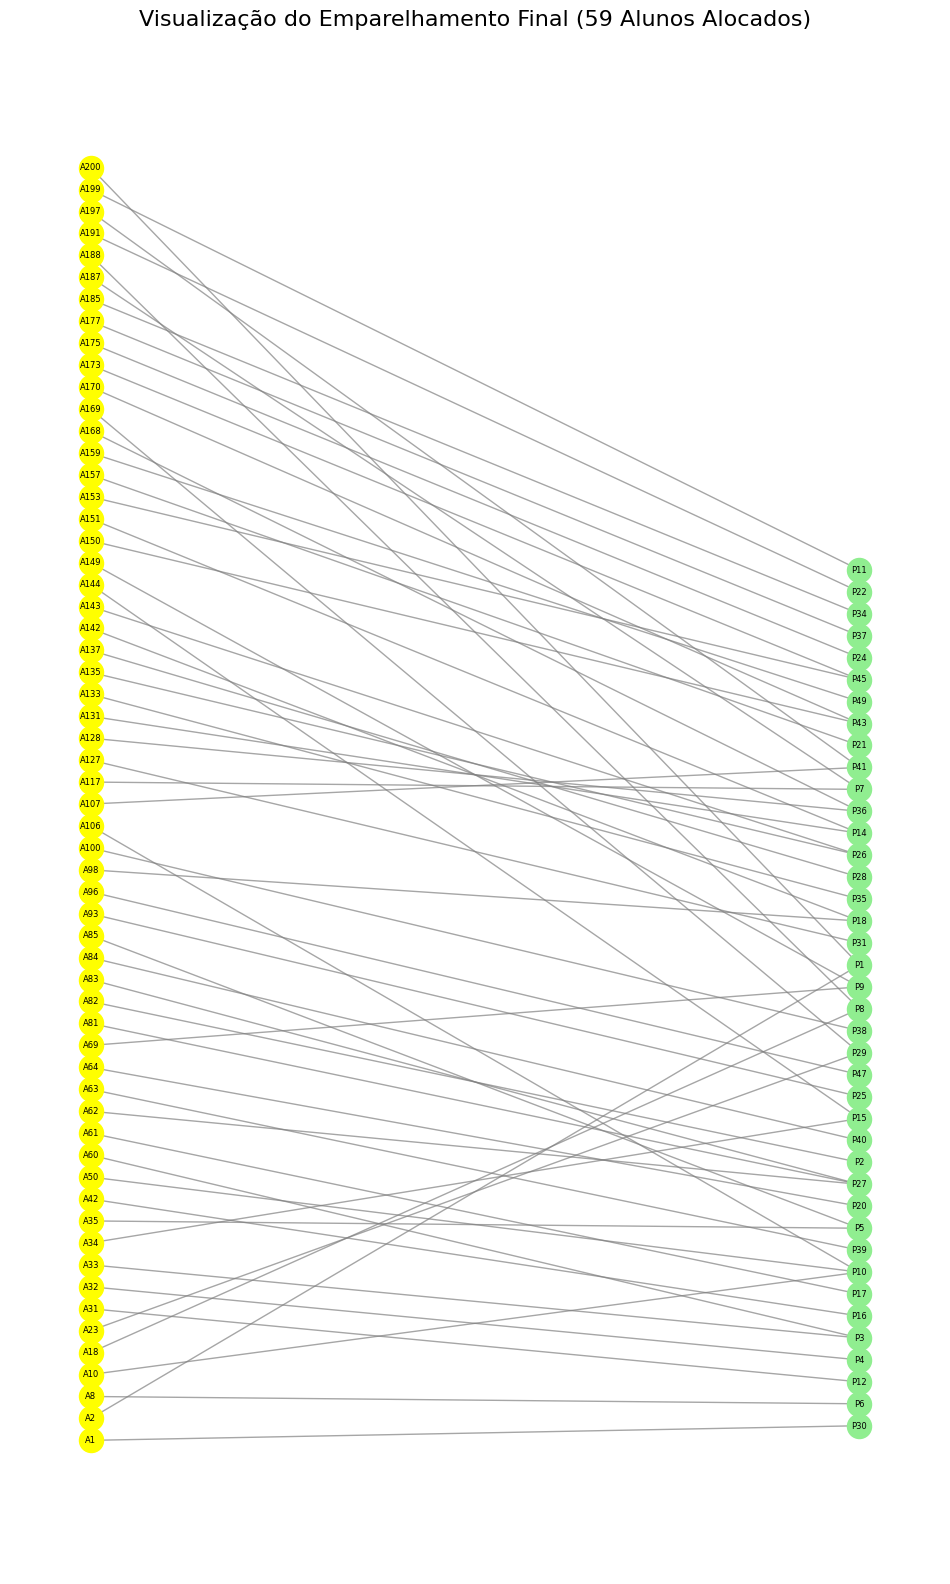

Gale-Shapley Variante 1


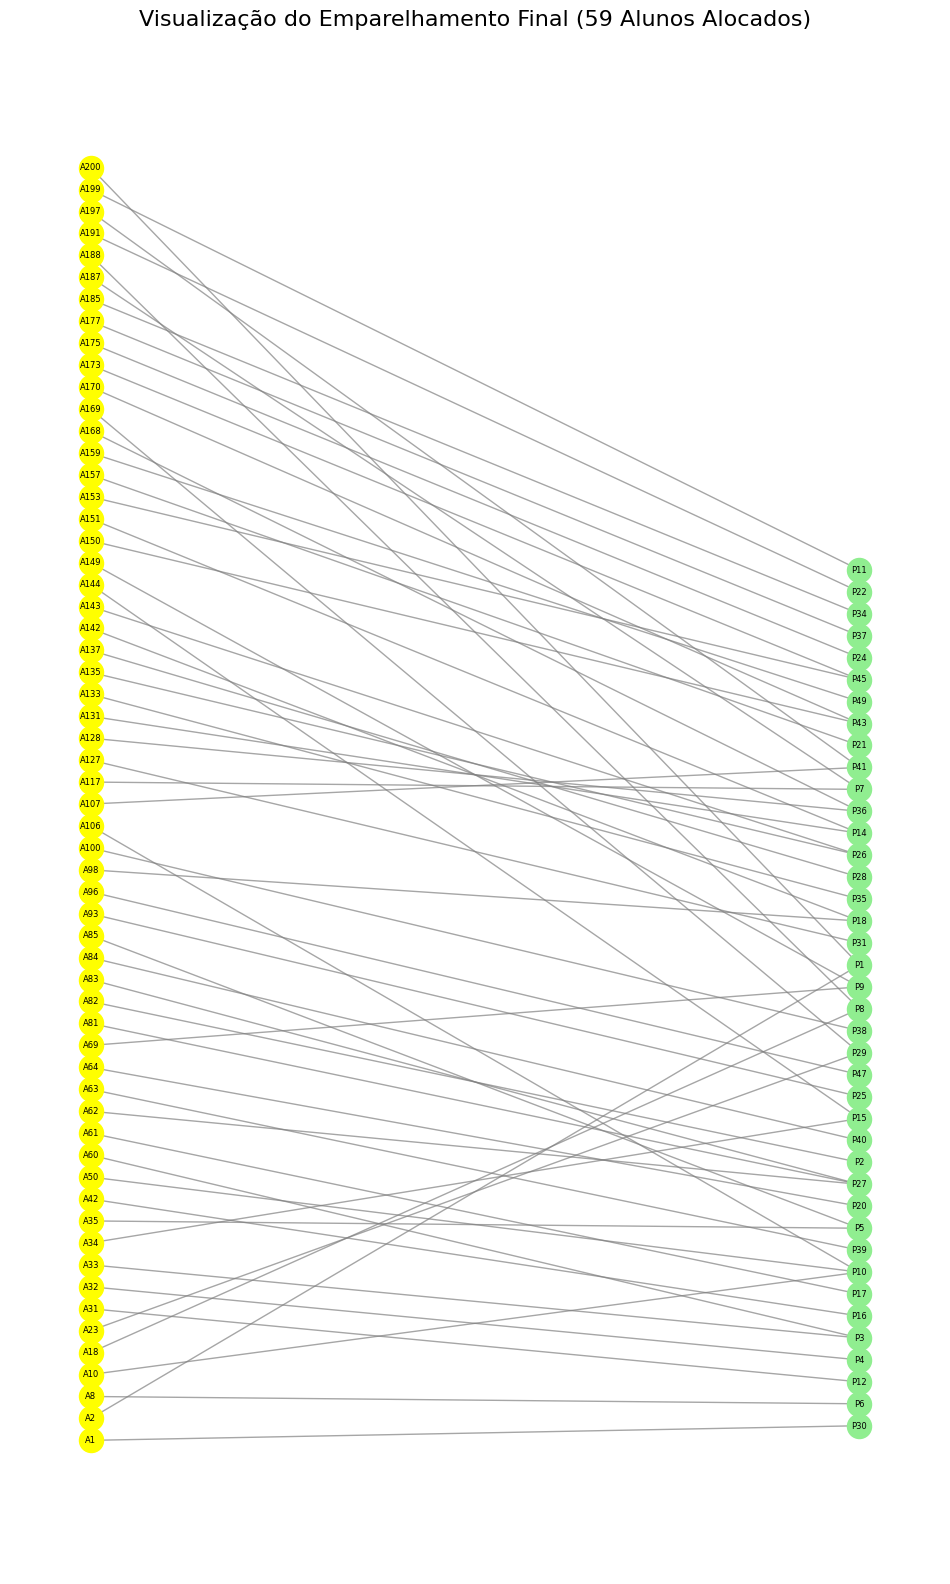

Gale-Shapley Variante 2


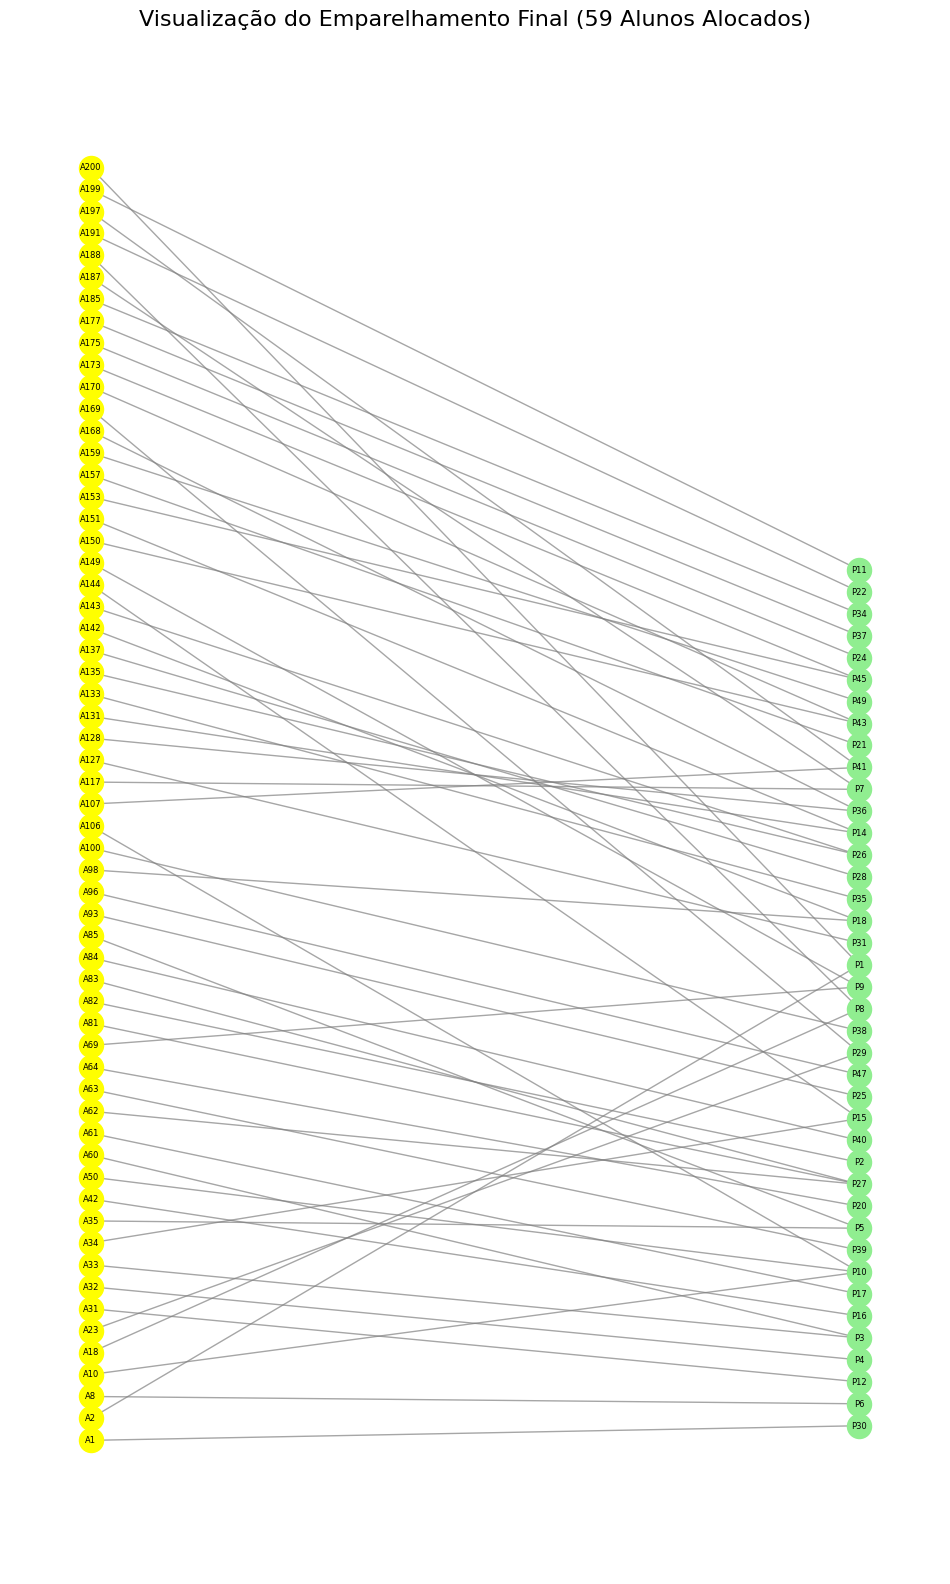

------ DEZ ITERAÇÕES COM INICIO EM POSIÇÕES DISTINTAS ------
Iteração 1


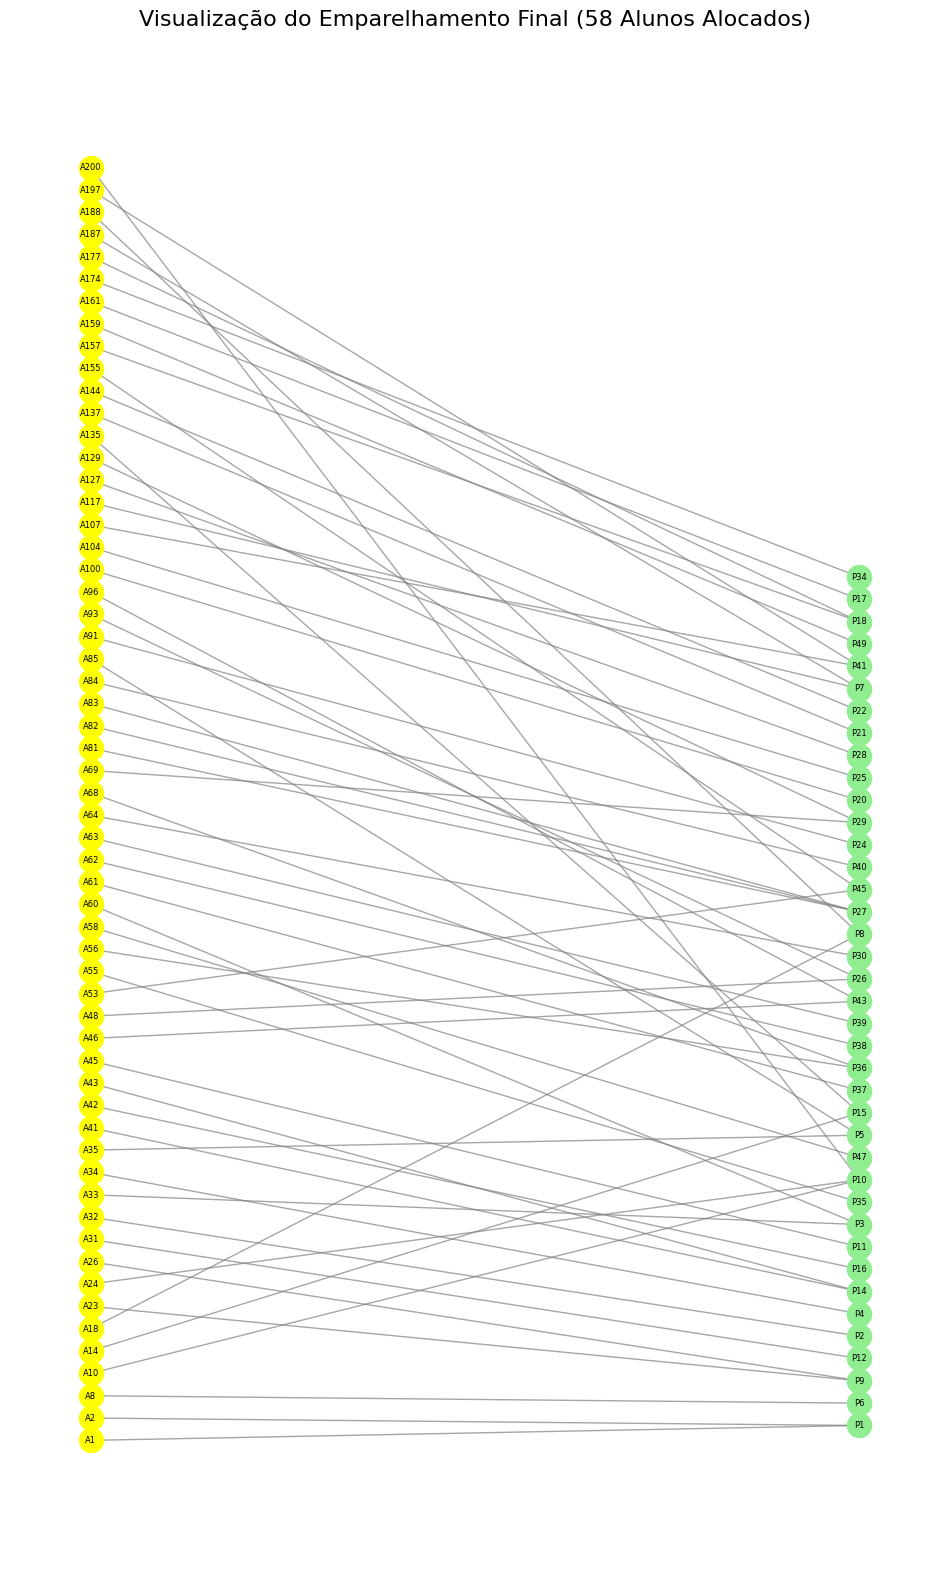

Iteração 2


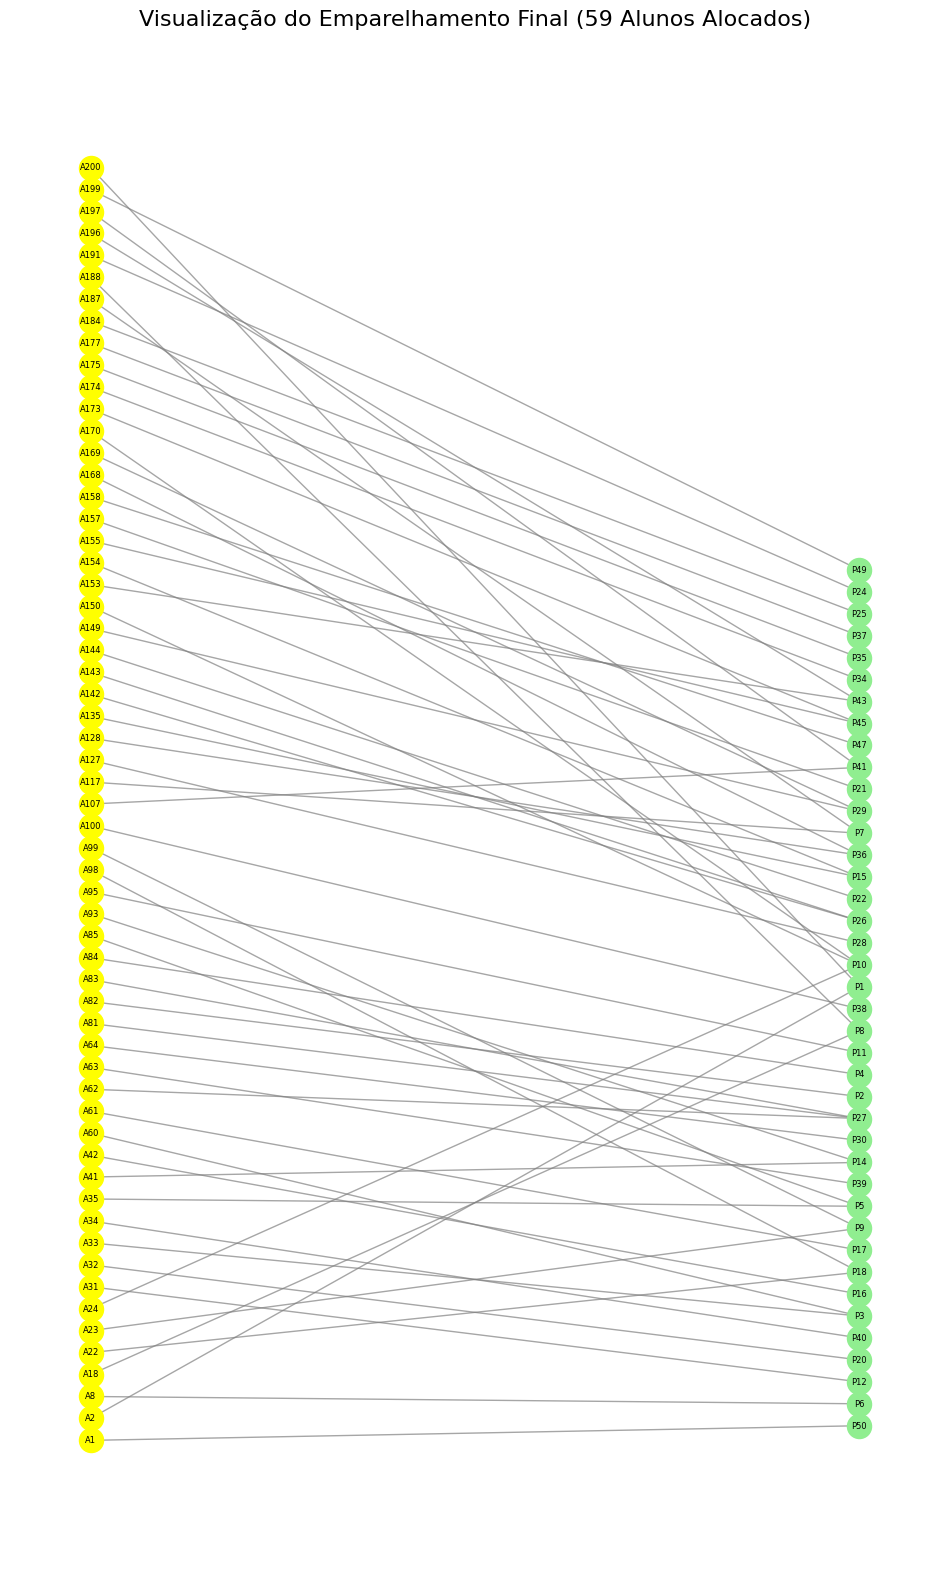

Iteração 3


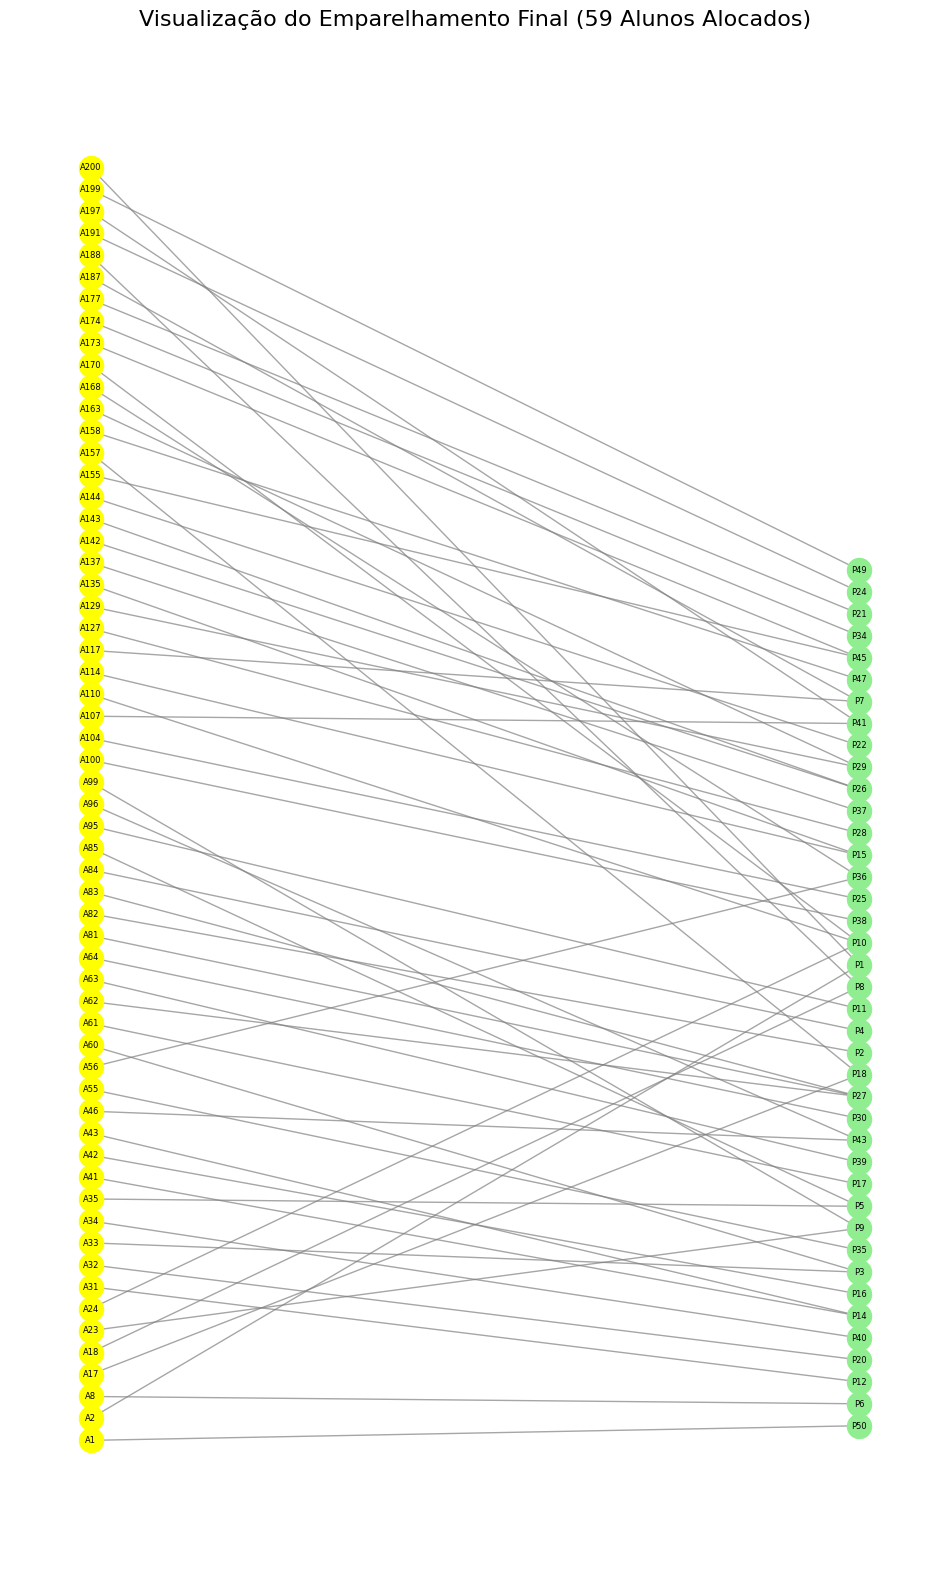

Iteração 4


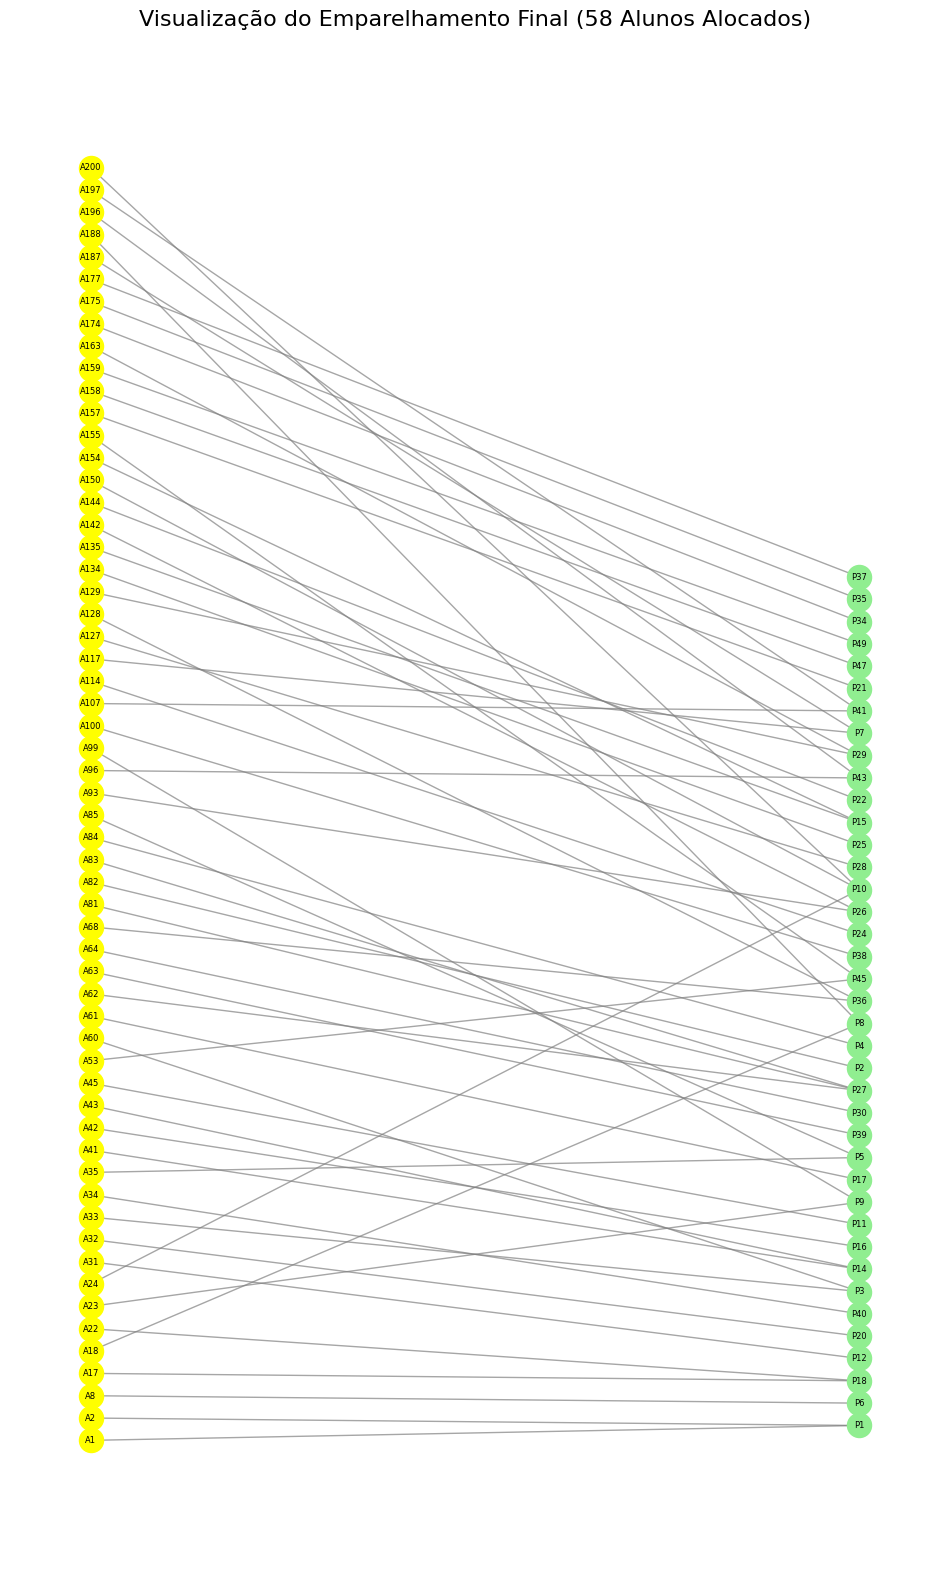

Iteração 5


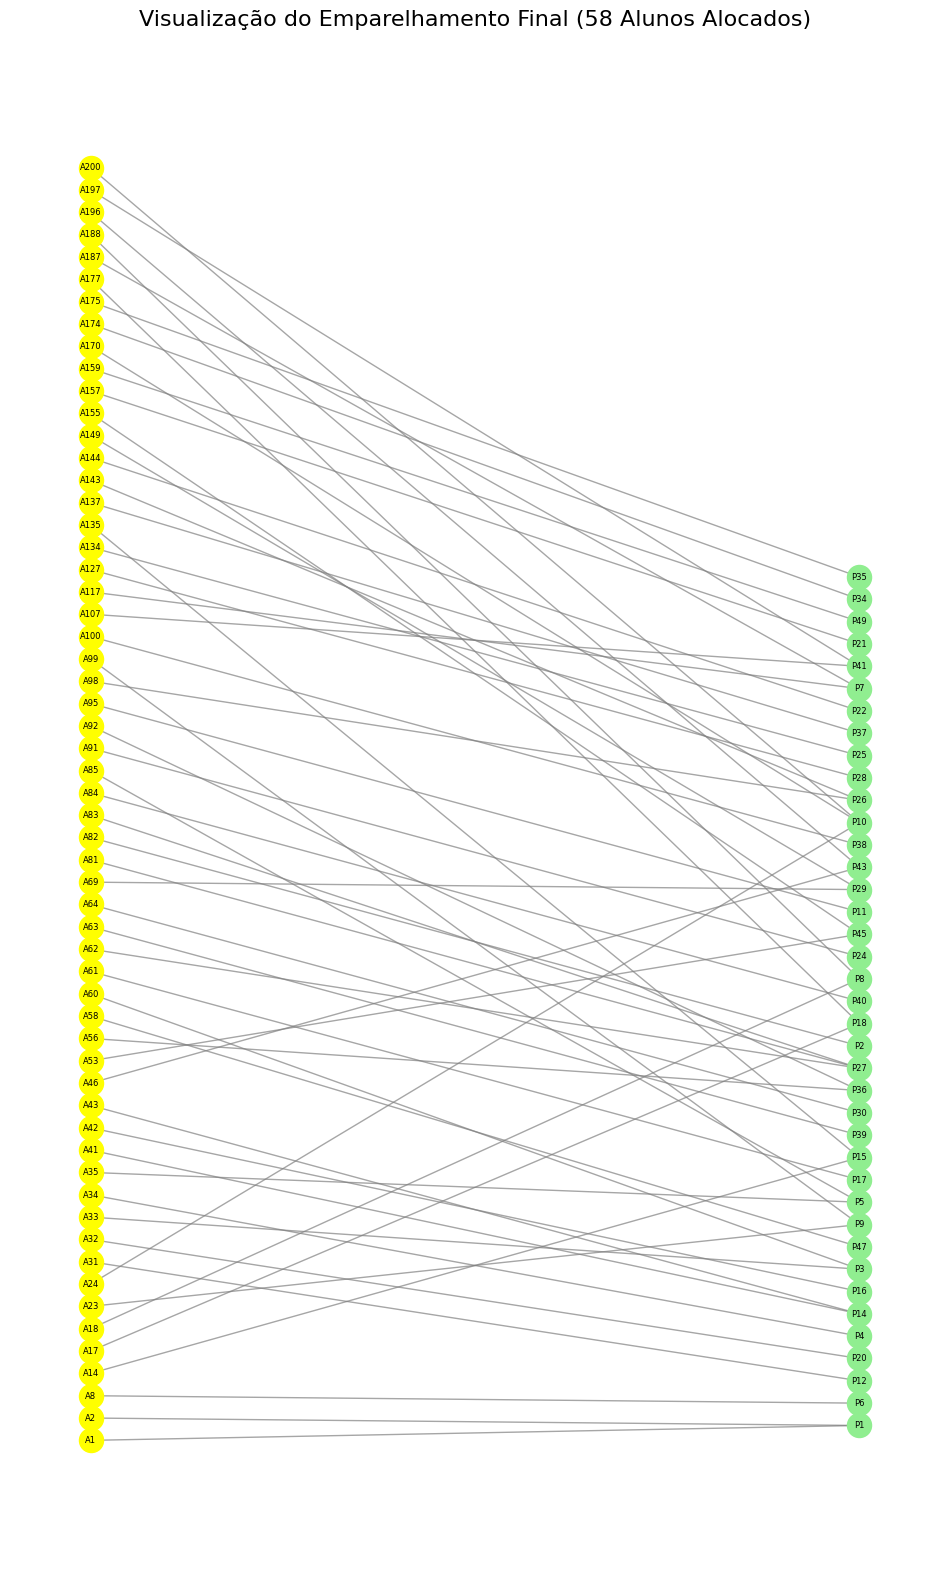

Iteração 6


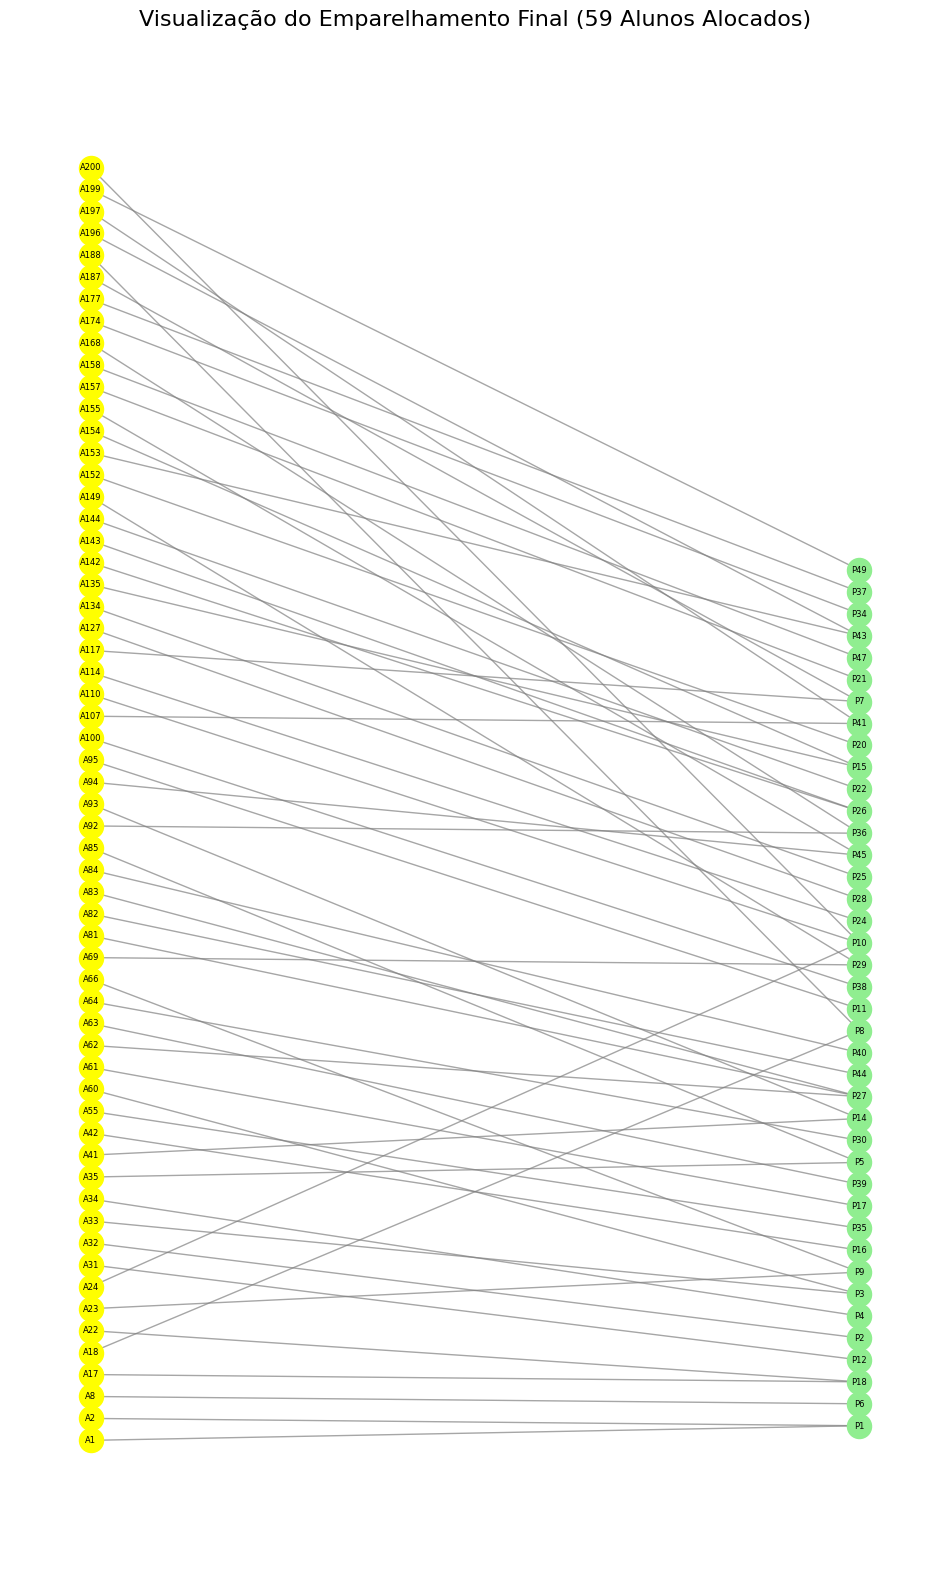

Iteração 7


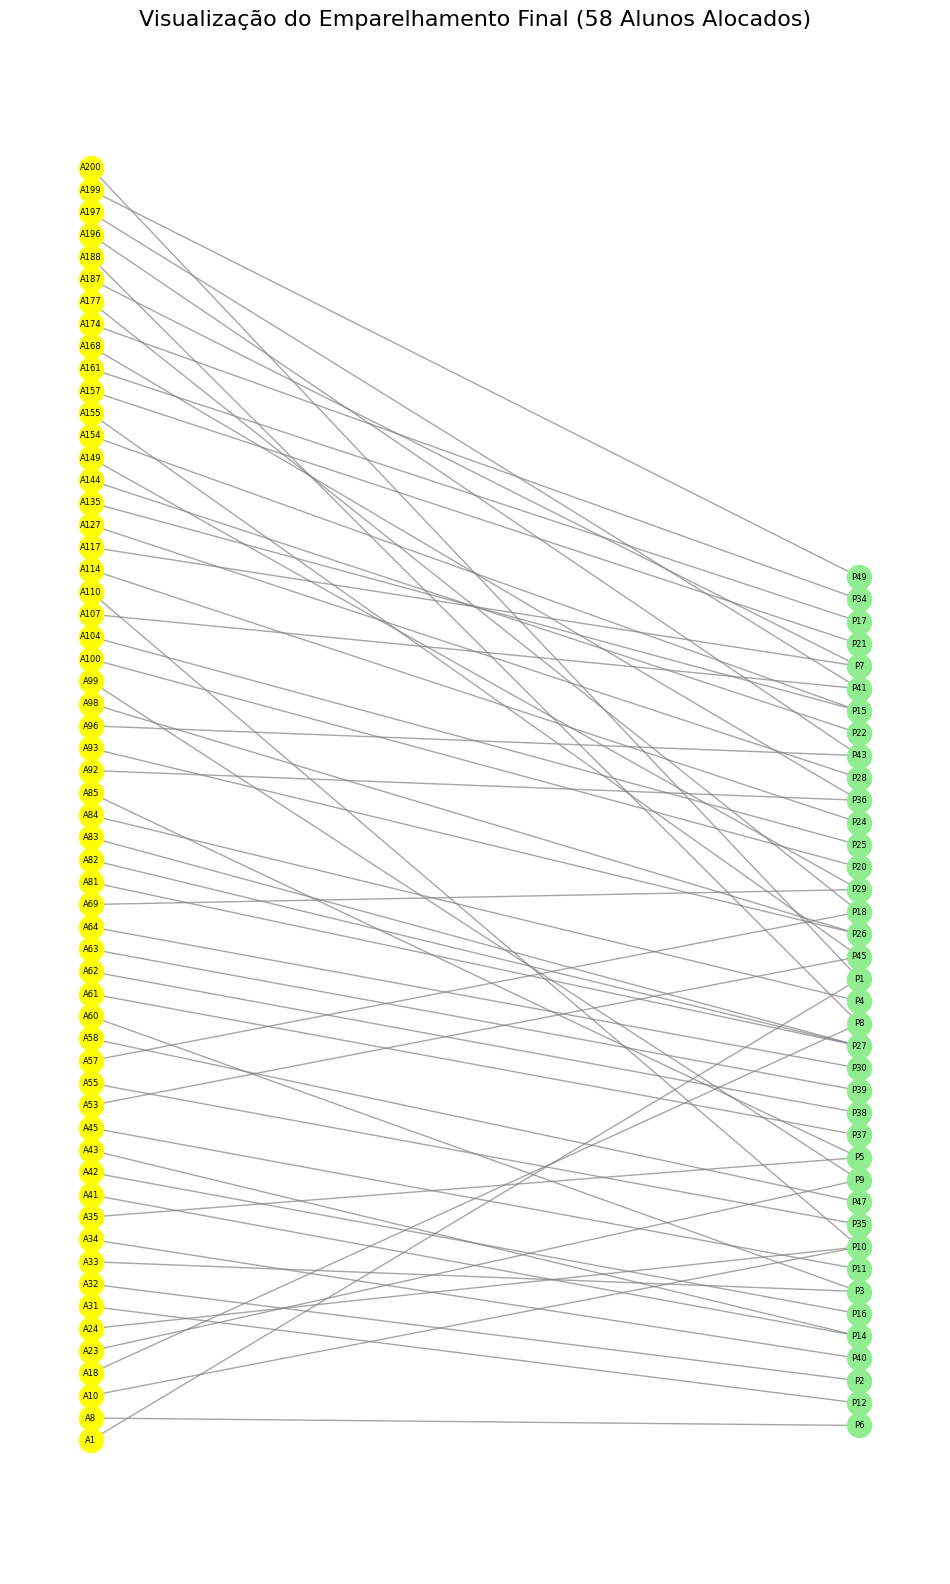

Iteração 8


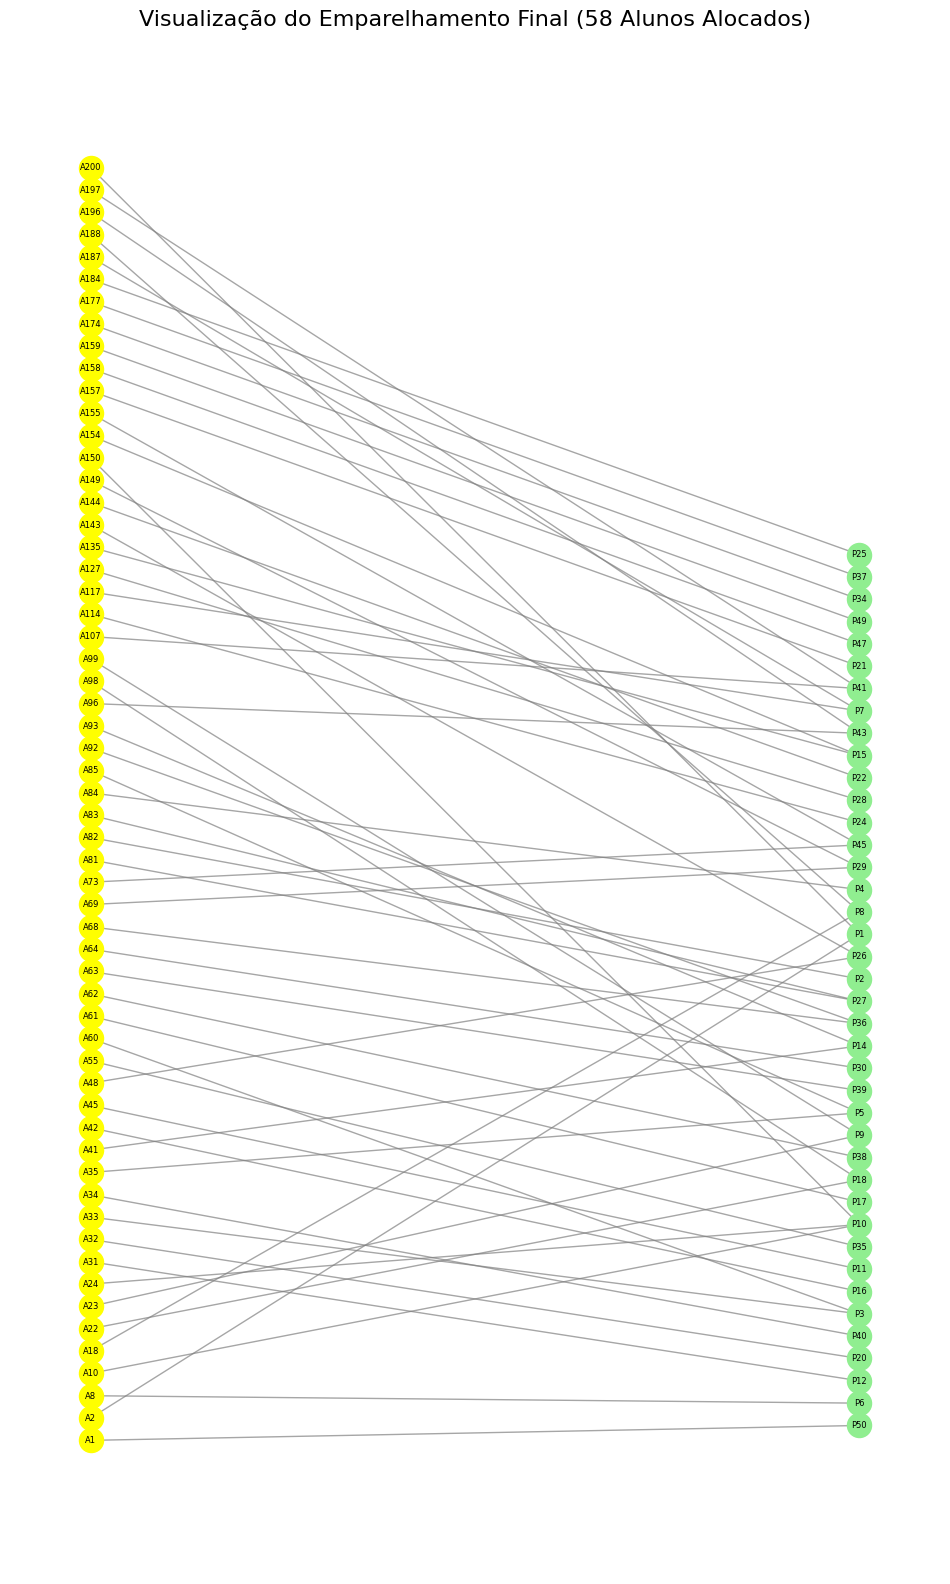

Iteração 9


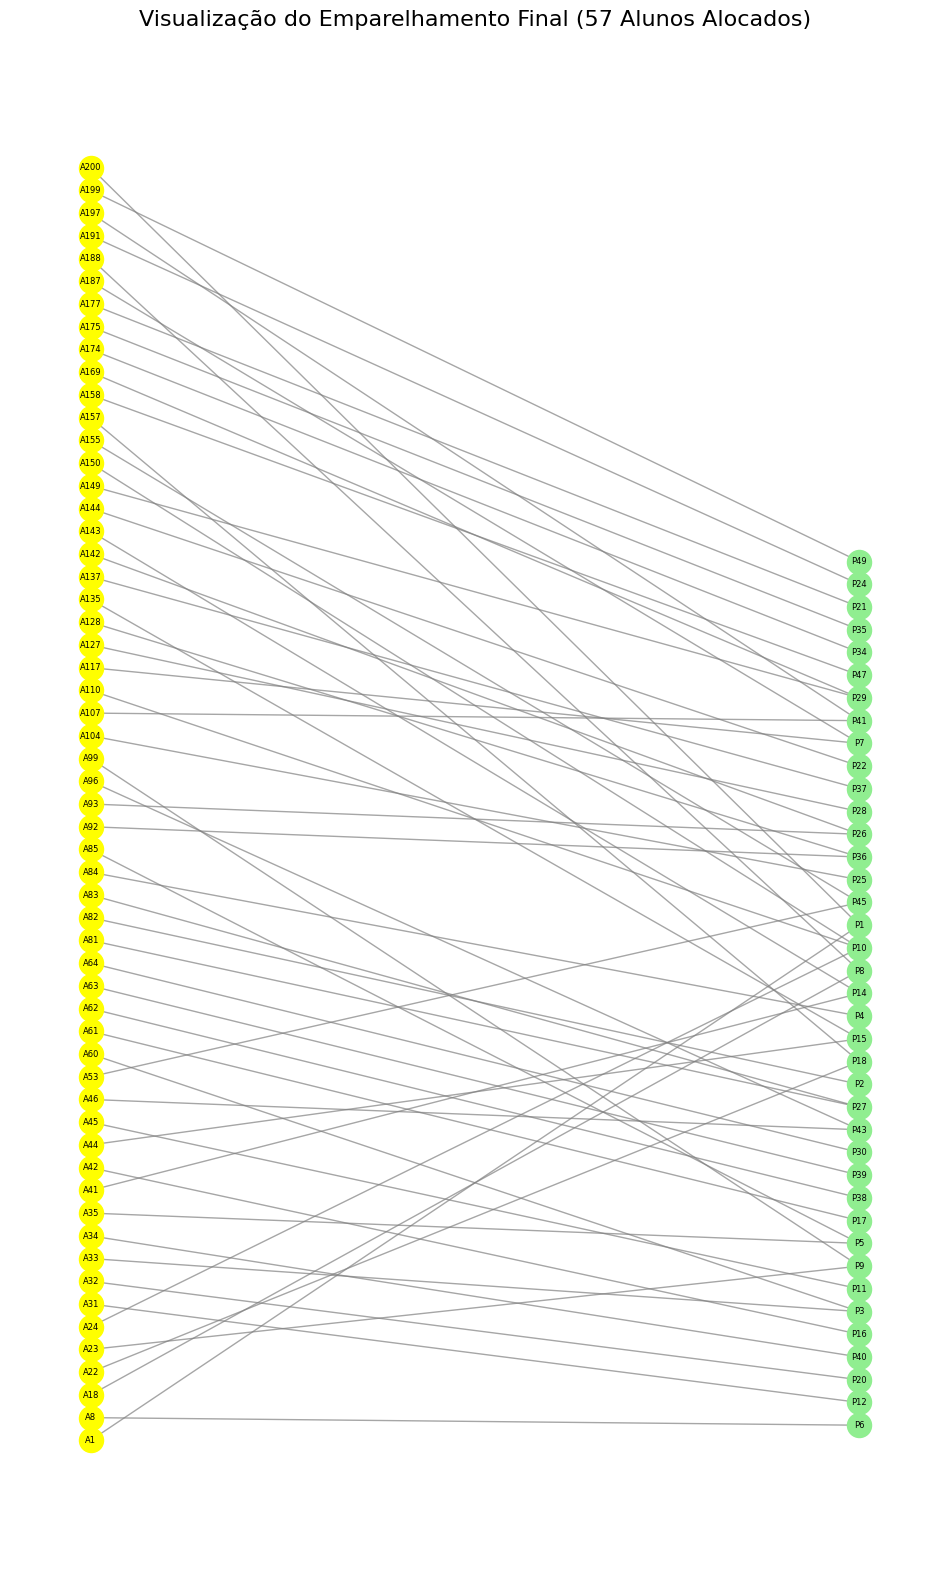

Iteração 10


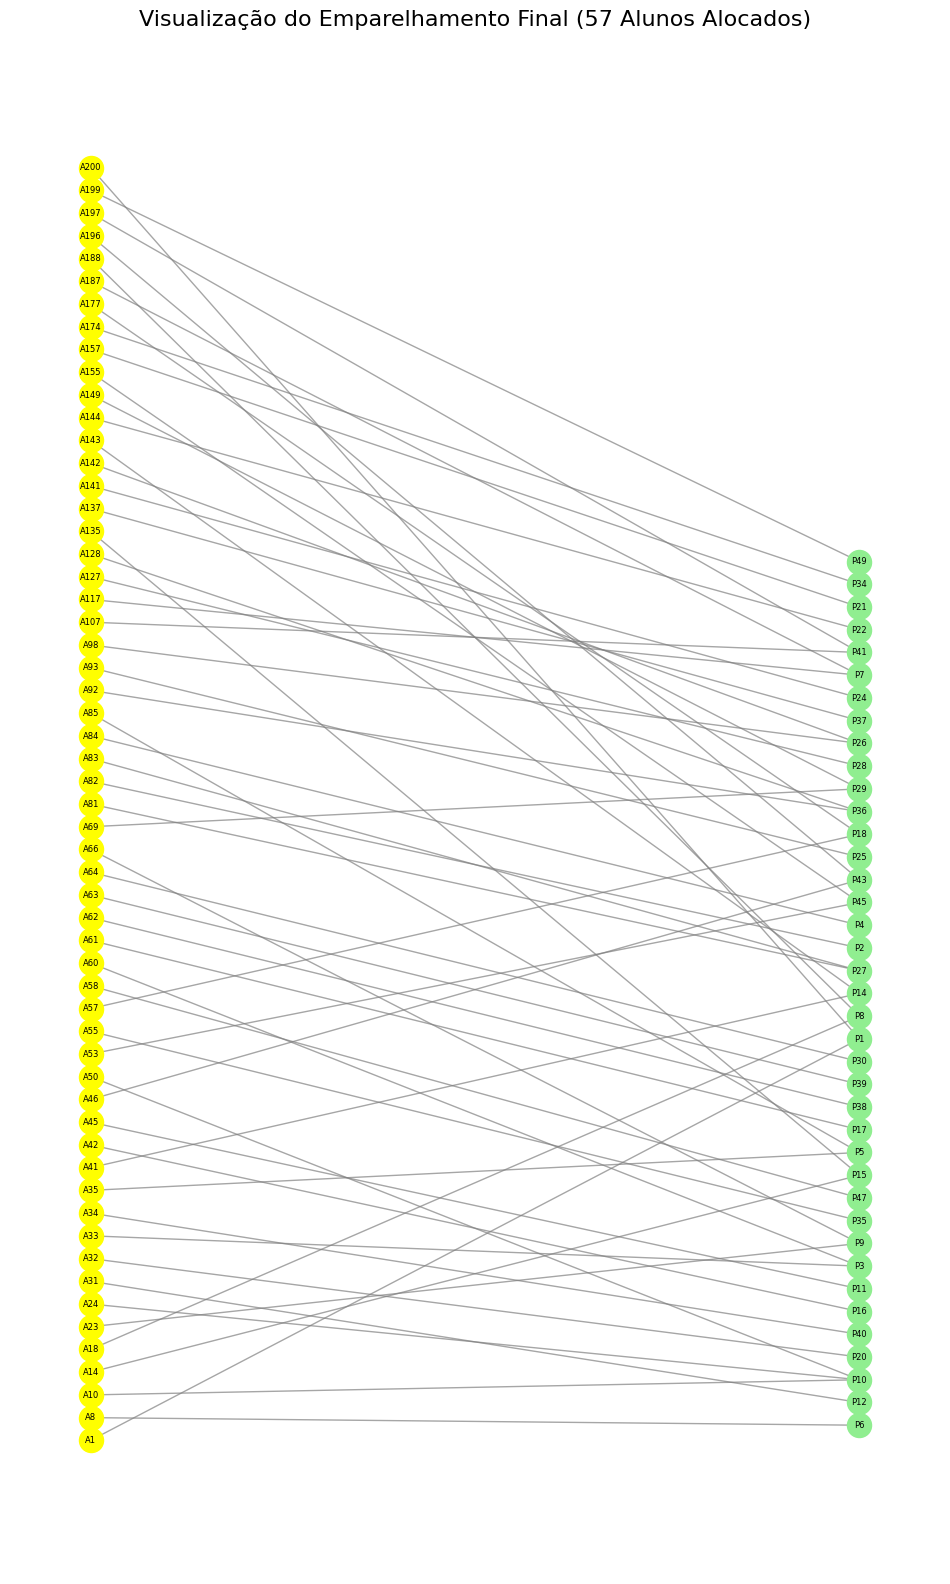

In [17]:
print('Gale-Shapley Normal')
fazerGrafo(DadosProcessados1)
print('Gale-Shapley Variante 1')
fazerGrafo(DadosProcessados2)
print('Gale-Shapley Variante 2')
fazerGrafo(DadosProcessados3)
print('------ DEZ ITERAÇÕES COM INICIO EM POSIÇÕES DISTINTAS ------')
for i in range(1, 11):
    print(f'Iteração {i}')
    DadosProcessados = galeShapley(alunos, projetos, i)
    fazerGrafo(DadosProcessados)